# FastCHO Gene Set Visualization

This notebook visualizes gene set associations from **CRISPR screen results**.  
It generates **bar plots** and **heatmaps** highlighting gene prevalence across biological functional groups.

---

## Notebook Overview  
- Load gene set annotations from `Final_Gene_Sets.xlsx`.  
- Map genes to high-level functional categories.

---

## Visualizations  
- **Top genes** and their gene set coverage (**bar plot**).  
- **Heatmap** of gene presence across functional categories.  
- **Grouped biological theme frequencies** (**bar plot**).  

---

## Input/Output  
- **Input File**: `./input_data/Final_Gene_Sets.xlsx`  
- **Output Figures**: Saved to `./output_data/`  

---

## Requirements  
- Ensure all required Python packages are installed via `requirements.txt`.  
- *Tip*: Modify the `abbreviations` dictionary in the script to customize biological category labels.

---

> **Author**: Jannis P. Marzluf  
> **Date**: 11.05.2025  


<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Jannis.Marzluf\AppData\Local\Temp\ipykernel_9488\3487040233.py:45: SyntaxWarning: invalid escape sequence '\s'
  df['Genes'] = df['Genes'].str.split(',\s*', regex=True)
C:\Users\Jannis.Marzluf\AppData\Local\Temp\ipykernel_9488\3487040233.py:46: SyntaxWarning: invalid escape sequence '\s'
  df['Assigned_Group'] = df['Assigned_Group'].str.split(';\s*', regex=True)


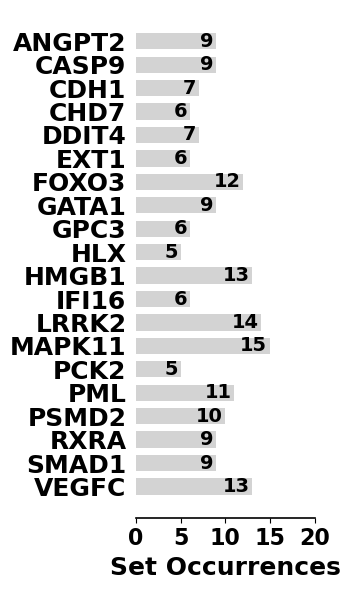

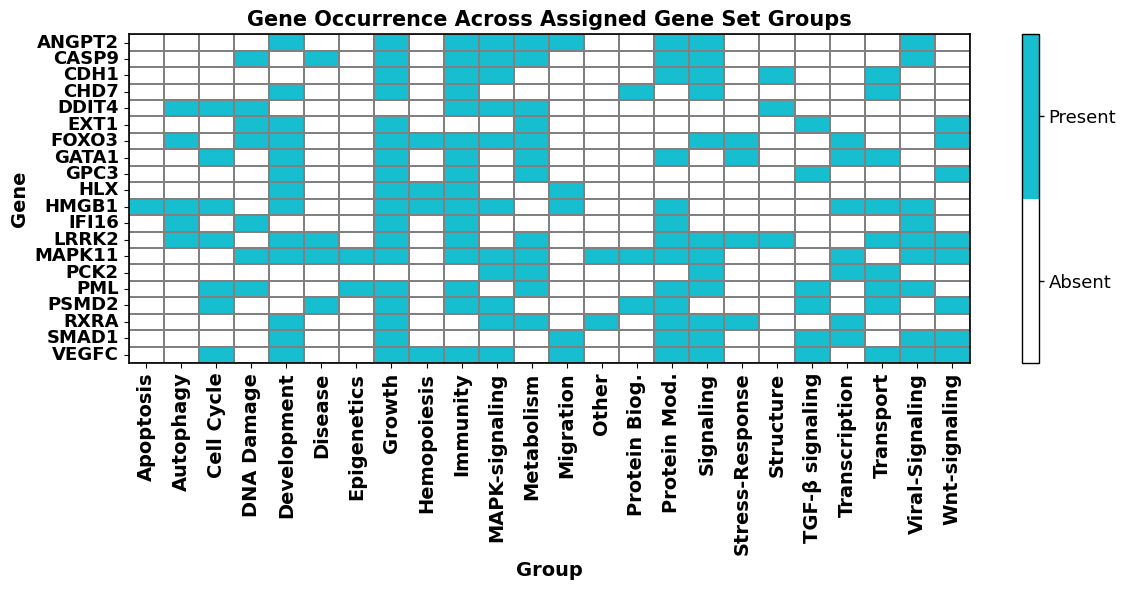

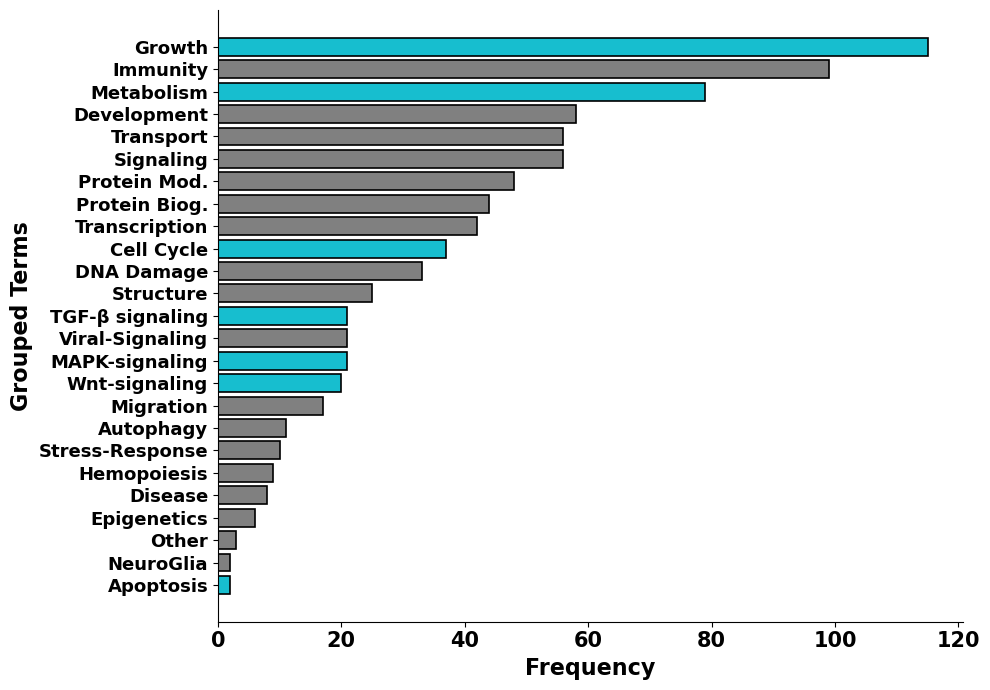

In [2]:

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# === Setup Paths ===
input_dir = "./input_data"
output_dir = "./output_data"
os.makedirs(output_dir, exist_ok=True)

input_file = os.path.join(input_dir, "Final_Gene_Sets.xlsx")

# === Load Data ===
abbreviations = {
    "Apoptosis and survival": "Apoptosis",
    "Autophagy and Catabolic Process": "Autophagy",
    "Cell cycle regulation": "Cell Cycle",
    "Cell structures and structural regulation": "Structure",
    "Cell Migration and Chemotaxis": "Migration",
    "Cellular Growth and Morphogenesis": "Growth",
    "Developmental and Tissue-Specific Processes": "Development",
    "Disease Biology": "Disease",
    "Energy and metabolism": "Metabolism",
    "Epigenetic regulation": "Epigenetics",
    "Immune Cell Regulation and Differentiation": "Immunity",
    "MAPK signaling": "MAPK-signaling",
    "Protein Biogenesis": "Protein Biog.",
    "Protein modification": "Protein Mod.",
    "Signaling pathways": "Signaling",
    "Stress response to DNA damage": "DNA Damage",
    "TGF-beta signaling": "TGF-β signaling",
    "Transcription and transcriptional regulation": "Transcription",
    "Transport processes": "Transport",
    "Viral and Inflammatory Signaling": "Viral-Signaling",
    "Wnt signaling pathway": "Wnt-signaling",
    "Not Assigned": "Other",
    "Cellular Stress and Stimulus Response": "Stress-Response",
    "Hemopoiesis": "Hemopoiesis",
    "Neural and Glial Differentiation": "NeuroGlia"
}

df = pd.read_excel(input_file)

df['Genes'] = df['Genes'].str.split(',\s*', regex=True)
df['Assigned_Group'] = df['Assigned_Group'].str.split(';\s*', regex=True)

records = []
for _, row in df.iterrows():
    for gene in row['Genes']:
        for group in row['Assigned_Group']:
            group_abbrev = abbreviations.get(group.strip(), group.strip())
            records.append((gene.strip(), group_abbrev))

long_df = pd.DataFrame(records, columns=["Gene", "Group"])

# === Top 20 Genes Analysis ===
top_genes = long_df['Gene'].value_counts().nlargest(20).index
filtered_df = long_df[long_df['Gene'].isin(top_genes)]
heat_matrix = filtered_df.pivot_table(index='Gene', columns='Group', aggfunc=lambda x: 1, fill_value=0)
heat_matrix = heat_matrix[sorted(heat_matrix.columns)]
gene_set_count = heat_matrix.sum(axis=1)

# === Plot: Bar Plot ===
plt.figure(figsize=(3.5, 6))
y_positions = range(len(heat_matrix.index))
aligned_counts = gene_set_count.loc[heat_matrix.index]

plt.barh(y=y_positions, width=aligned_counts, color='lightgray', height=0.7)

for i, count in enumerate(aligned_counts):
    plt.text(count - 0.3, i, str(int(count)), va='center', ha='right',
             fontsize=14, color='black', weight='bold')

plt.xlim(0, 20)
plt.xlabel("Set Occurrences", fontsize=18, weight='bold')
plt.xticks(fontsize=16, weight='bold')
plt.yticks(y_positions, heat_matrix.index, fontsize=18, weight='bold')
plt.gca().invert_yaxis()
plt.tick_params(axis='y', left=False)

ax = plt.gca()
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_linewidth(1.2)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "bar_gene_set_counts_improved.png"), dpi=300, transparent=True)
plt.show()

# === Plot: Heatmap ===
plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    heat_matrix,
    cmap=["white", "#17becf"],
    linewidths=1.2,
    linecolor='gray',
    cbar_kws={'ticks': [0.25, 0.75], 'orientation': 'vertical'}
)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(['Absent', 'Present'])
colorbar.ax.tick_params(labelsize=13, width=1)
colorbar.outline.set_visible(True)
colorbar.outline.set_edgecolor('black')
colorbar.outline.set_linewidth(1)

plt.xticks(rotation=90, fontsize=14, weight='bold')
plt.yticks(fontsize=13, weight='bold')
plt.xlabel("Group", fontsize=14, weight='bold')
plt.ylabel("Gene", fontsize=14, weight='bold')
plt.title("Gene Occurrence Across Assigned Gene Set Groups", fontsize=15, weight='bold')

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "heatmap_gene_group_presence_updated.png"), dpi=300, transparent=True)
plt.show()

# === Plot: Grouped Term Frequencies ===
group_freq = long_df['Group'].value_counts().sort_values(ascending=True)

highlight_groups = ["Growth", "Metabolism", "Cell Cycle", "MAPK-signaling", "TGF-β signaling", "Wnt-signaling", "Apoptosis"]
colors = ['#17becf' if group in highlight_groups else 'gray' for group in group_freq.index]

plt.figure(figsize=(10, 7))
bars = plt.barh(
    group_freq.index,
    group_freq.values,
    color=colors,
    edgecolor='black',
    linewidth=1.2
)

plt.xlabel("Frequency", fontsize=16, weight='bold')
plt.ylabel("Grouped Terms", fontsize=16, weight='bold')
plt.xticks(fontsize=15, weight='bold')
plt.yticks(fontsize=13, weight='bold')

for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "grouped_term_frequencies_bordered.png"), dpi=300, transparent=True)
plt.show()
